In [1]:
from IPython.utils import io
import csv
with io.capture_output() as captured:  
   %run ../../2-FeatureExtraction/OneHot/OneHot.ipynb import x, y1, y2, X, Y1, Y2, vocabulary, Preprocessing, Features

#### Imports

In [2]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import gensim.downloader as api

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(device)

cpu


#### Loading the Preprocessed Data

In [4]:
print(x) # for each tweet, each word is just represnted by its index in the vocab
print(x.shape)
train_data = TensorDataset(torch.from_numpy(x), torch.from_numpy(y1))
valid_data = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y1))

print(train_data)
print(train_data[0][0])
print(train_data[1])
batch_size = 128

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=1024)

[[21095 14645 20776 ... 19177 14633 11862]
 [15234 13869 21075 ...  2744 12262 10533]
 [23385 16581   456 ...  6973  6973  6973]
 ...
 [ 3667  7734 15418 ...  6973  6973  6973]
 [ 5415 15072  9176 ...  6973  6973  6973]
 [ 7333  4430  1280 ...  6973  6973  6973]]
(6988, 30)
tensor([21095, 14645, 20776, 15418, 21196,  6671, 15446,  3180,  1269, 20394,
        12656,  7491,  6100, 24998, 22480, 14745,  7713, 15096, 21267, 14162,
        16452,  6904, 25476,  5436, 11922, 14633, 18713, 19177, 14633, 11862],
       dtype=torch.int32)
(tensor([15234, 13869, 21075,   686, 11754, 21844,  4188, 21782, 22615,  9886,
           25,  4637, 14633,  9574, 16268,  8540, 13688, 15833, 11179, 20127,
        16577, 18713,  9323,    25,  3676,   752,  3151,  2744, 12262, 10533],
       dtype=torch.int32), tensor(1))


#### Creating the Model

In [5]:
class SequenceModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim,  hidden_dim, output_dim,  num_layers, drop_prob=0.5):
        super().__init__()

        # Network Dimensions
        self.vocab_size, self.hidden_dim, self.output_dim  = vocab_size, hidden_dim, output_dim
        self.num_layers = num_layers
    
        # Embedding Layer
        # t_model = gensim.models.Word2Vec.load('models/full_grams_cbow_100_twitter.mdl')
        # load the whole embedding into memory
        # w2v_embeddings_index={}
        # TOTAL_EMBEDDING_DIM=embedding_dim
        # # embeddings_file='models/full_grams_cbow_100_twitter.mdl'
        # # w2v_model =Word2Vec.load(embeddings_file)
        # w2v_model = Word2Vec.load('../../2-FeatureExtraction/WordEmbeddings/embedding_models/full_grams_cbow_300_twitter.mdl')
        # for word in w2v_model.wv.index_to_key:
        #     # w2v_embeddings_index[word] = w2v_model[word]
        #     w2v_embeddings_index[word] = w2v_model.wv.get_index(word)
        # print('Loaded %s word vectors.'% len(w2v_embeddings_index))

        # # create a weight matrix for words in training docs
        # embedding_matrix = np.zeros((vocab_size, TOTAL_EMBEDDING_DIM))
        # # for word, i in train_data.items():
        # for i, word in enumerate(train_data):
        #     embedding_vector = w2v_embeddings_index.get(word)
        #     if embedding_vector is not None:
        #         embedding_matrix[i] = embedding_vector
        # print('Embedding Matrix shape:', embedding_matrix.shape)

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # self.embedding.weights = torch.nn.Parameter(torch.from_numpy(embedding_matrix))

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=self.hidden_dim, num_layers=num_layers, batch_first=True)
        
        # Drop out layer
        self.dropout = nn.Dropout(0.3)
    
        # Output Layer
        self.output = nn.Linear(self.hidden_dim, output_dim)      # Or make it linear and use Sofrmax (in loss)
   
    def forward(self, x):

        embeds = self.embedding(x)                                          # B * Seq_Len * embedding_dim
        
        lstm_out, _ = self.lstm(embeds)                                     # B * Seq_Len * hidden_dim
        
        lstm_out =  lstm_out[:, -1, :]                                      # B * hidden_dim

        drop_out = self.dropout(lstm_out)                                   # B * hidden_dim

        
        out = self.output(drop_out)                                         # B * output_dim
        
        return out
        

#### Initializing the Model

In [6]:
num_layers = 2
vocab_size = len(vocabulary)
embedding_dim = 200
output_dim = 3
hidden_dim = 256
drop_prob = 0.5
lr=0.001
clip = 5
epochs = 5 

ModelInfo = {
   "Model": "LSTM-1",
   "batch_size": batch_size,
   "Number of Layers": num_layers,
   "Embedding Dimension": embedding_dim,
   "Hidden Dimension": hidden_dim,
   "Dropout Prob": drop_prob,
   "Learning Rate": lr,
   "Gradient Clip": clip,
   "Number of Epochs": epochs
}

model = SequenceModel(vocab_size, embedding_dim,  hidden_dim, output_dim,  num_layers).to(device)

print(model)

SequenceModel(
  (embedding): Embedding(25593, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=256, out_features=3, bias=True)
)


#### Training & Validating the Model

In [7]:
# loss and optimization functions
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [8]:
epoch_tr_loss, epoch_vl_loss = [], []

for epoch in range(epochs):
    train_losses = []
    for inputs, labels in tqdm(train_loader):
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # print('hii', inputs.shape)
        output = model(inputs)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
    val_losses = []
    for inputs, labels in valid_loader:
        with torch.no_grad():
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            val_loss = criterion(output, labels)
            val_losses.append(val_loss.item())

        if epoch == epochs-1:
            F1 = f1_score(labels.cpu().numpy(), output.argmax(1).cpu().numpy(), average='macro')
            Report = classification_report(labels.cpu().numpy(), output.argmax(1).cpu().numpy(), output_dict=True)
            print(classification_report(labels.cpu().numpy(), output.argmax(1).cpu().numpy()))         
            
                        
    
    epoch_tr_loss.append(np.mean(train_losses))
    epoch_vl_loss.append(np.mean(val_losses))
    print(f'Epoch {epoch+1}') 
    print(25*'==')

print("Macro F1 Score: ", F1)



100%|██████████| 55/55 [00:19<00:00,  2.81it/s]


Epoch 1


100%|██████████| 55/55 [00:19<00:00,  2.89it/s]


Epoch 2


100%|██████████| 55/55 [00:18<00:00,  2.97it/s]


Epoch 3


100%|██████████| 55/55 [00:19<00:00,  2.89it/s]


Epoch 4


100%|██████████| 55/55 [00:18<00:00,  2.96it/s]


              precision    recall  f1-score   support

           0       0.31      0.40      0.35       126
           1       0.88      0.90      0.89       804
           2       0.40      0.06      0.10        70

    accuracy                           0.78      1000
   macro avg       0.53      0.45      0.44      1000
weighted avg       0.77      0.78      0.76      1000

Epoch 5
Macro F1 Score:  0.4448055530499611


#### Saving Run Info

In [9]:
with open('runs.csv', 'a') as f:  
      run_info = {**Preprocessing, **Features, **ModelInfo, "acc":Report["accuracy"],"BF1": Report["macro avg"]["f1-score"], "WF1": Report["weighted avg"]["f1-score"] }
      w = csv.DictWriter(f, run_info.keys())
      w.writeheader()
      w.writerow(run_info)

#### Loss and Accuracy

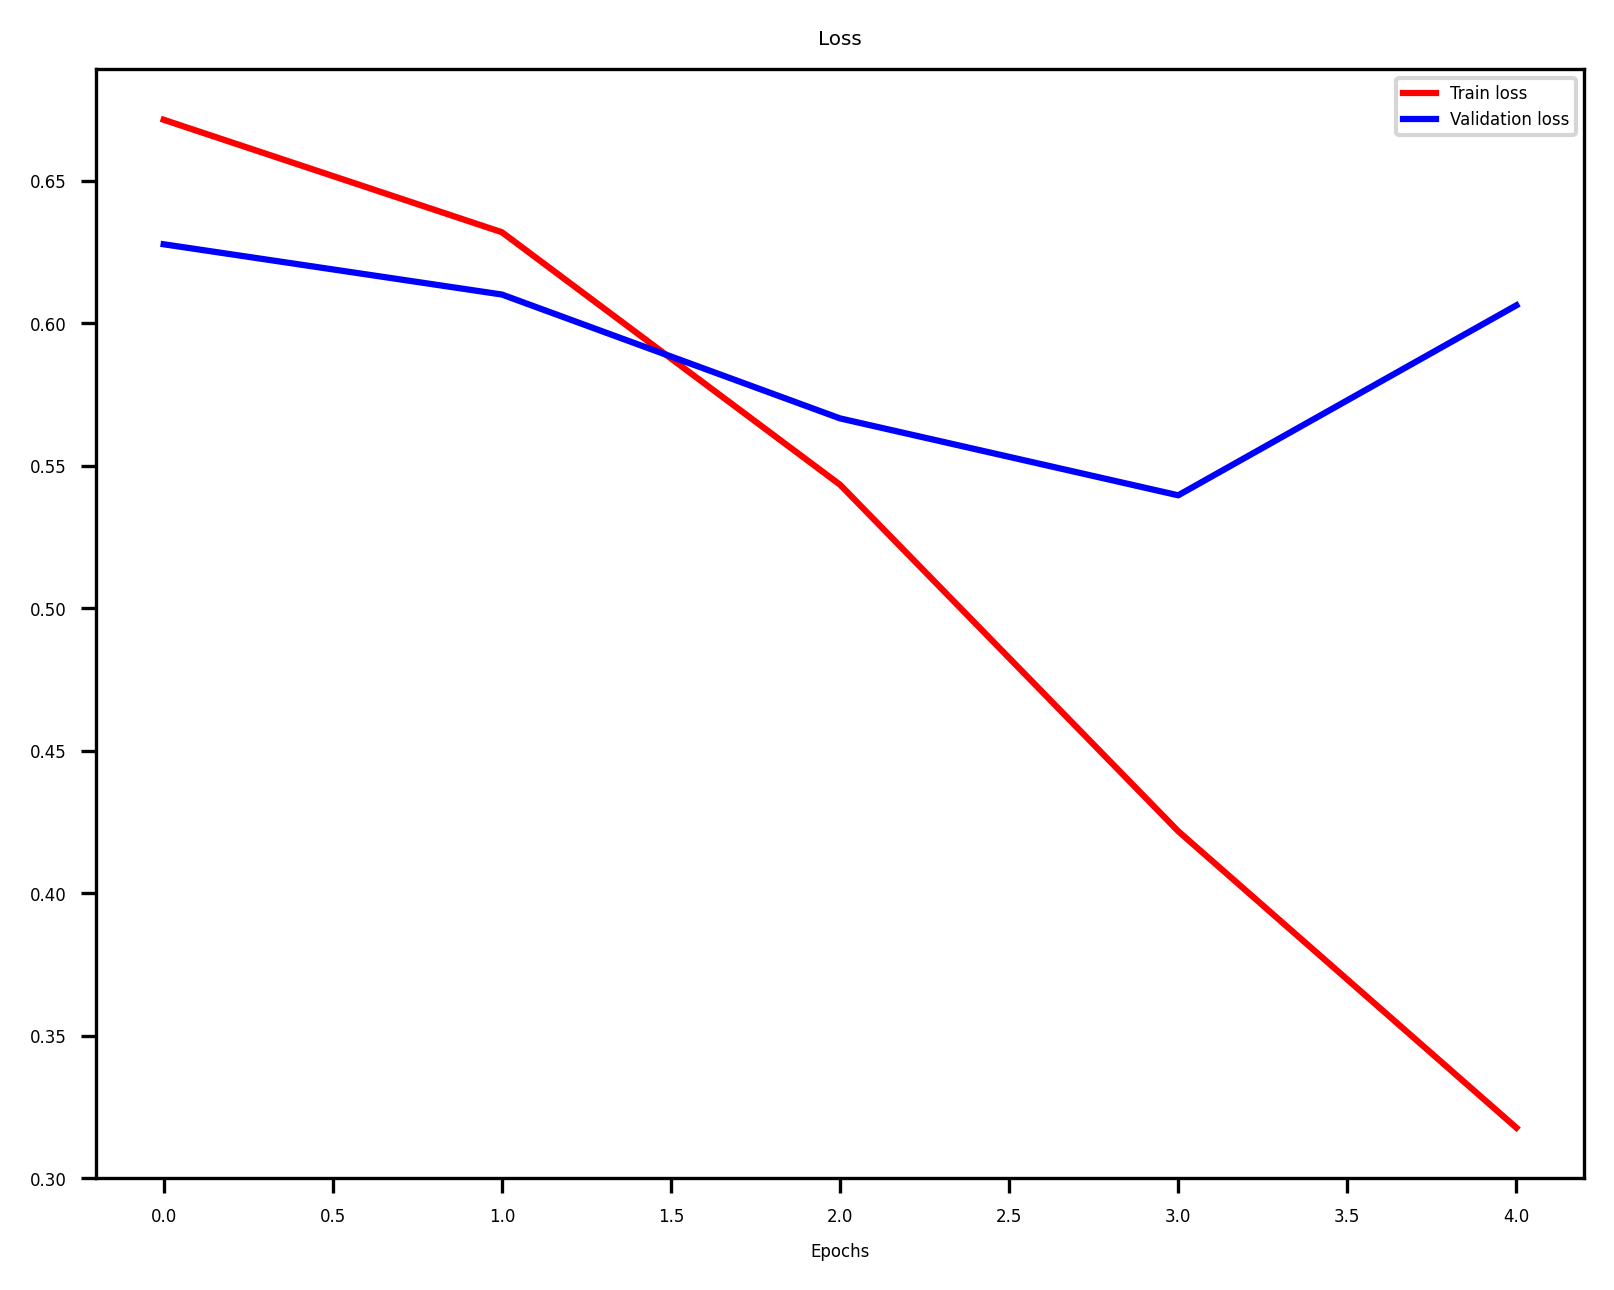

In [10]:
plt.plot(epoch_tr_loss, label='Train loss', color='red')
plt.plot(epoch_vl_loss, label='Validation loss', color='blue')
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()